# eNetV2_total_performance_check

The code is for google colaboratory. Please check that GPU is available before running this code.

code originally from https://colab.research.google.com/github/google/automl/blob/master/efficientnetv2/tfhub.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
drive_path = '/content/drive/MyDrive/efficientnet-v2'
import os
os.chdir(drive_path)

In [3]:
# !pip install tensorflow= 2.5.0
# !pip install tensorflow_hub= 0.12.0

In [4]:
import tensorflow_hub as hub
import json
import shutil
from skimage.io import imread, imsave
from glob import glob
import cv2
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime, timedelta, timezone
JST = timezone(timedelta(hours=+9), 'JST')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras.backend import sigmoid
from tensorflow_hub import KerasLayer

print('TF version:', tf.__version__)
print('Hub version:', hub.__version__)
print('Phsical devices:', tf.config.list_physical_devices())

TF version: 2.7.0
Hub version: 0.12.0
Phsical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
def get_hub_url_and_isize(model_name, ckpt_type, hub_type):
  if ckpt_type == '-1k':
    ckpt_type = ''  # json doesn't support empty string
  
  hub_url_map = {
    'efficientnetv2-b0': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0/{hub_type}',
    'efficientnetv2-b1': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1/{hub_type}',
    'efficientnetv2-b2': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2/{hub_type}',
    'efficientnetv2-b3': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3/{hub_type}',
    'efficientnetv2-s':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s/{hub_type}',
    'efficientnetv2-m':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m/{hub_type}',
    'efficientnetv2-l':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l/{hub_type}',
    'efficientnetv2-s-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k/{hub_type}',
    'efficientnetv2-m-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k/{hub_type}',
    'efficientnetv2-l-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k/{hub_type}',
    'efficientnetv2-s-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k-ft1k/{hub_type}',
    'efficientnetv2-m-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k-ft1k/{hub_type}',
    'efficientnetv2-l-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k-ft1k/{hub_type}',
      
    # efficientnetv1
    'efficientnet_b0': f'https://tfhub.dev/tensorflow/efficientnet/b0/{hub_type}/1',
    'efficientnet_b1': f'https://tfhub.dev/tensorflow/efficientnet/b1/{hub_type}/1',
    'efficientnet_b2': f'https://tfhub.dev/tensorflow/efficientnet/b2/{hub_type}/1',
    'efficientnet_b3': f'https://tfhub.dev/tensorflow/efficientnet/b3/{hub_type}/1',
    'efficientnet_b4': f'https://tfhub.dev/tensorflow/efficientnet/b4/{hub_type}/1',
    'efficientnet_b5': f'https://tfhub.dev/tensorflow/efficientnet/b5/{hub_type}/1',
    'efficientnet_b6': f'https://tfhub.dev/tensorflow/efficientnet/b6/{hub_type}/1',
    'efficientnet_b7': f'https://tfhub.dev/tensorflow/efficientnet/b7/{hub_type}/1',
  }
  
  image_size_map = {
    'efficientnetv2-b0': 224,
    'efficientnetv2-b1': 240,
    'efficientnetv2-b2': 260,
    'efficientnetv2-b3': 300,
    'efficientnetv2-s':  384,
    'efficientnetv2-m':  480,
    'efficientnetv2-l':  480,
  
    'efficientnet_b0': 224,
    'efficientnet_b1': 240,
    'efficientnet_b2': 260,
    'efficientnet_b3': 300,
    'efficientnet_b4': 380,
    'efficientnet_b5': 456,
    'efficientnet_b6': 528,
    'efficientnet_b7': 600,
  }
  
  hub_url = hub_url_map.get(model_name + ckpt_type)
  image_size = image_size_map.get(model_name, 224)
  return hub_url, image_size


## 3.Inference with Panda image

In [6]:
# # Build model
# import tensorflow_hub as hub
# model_name = 'efficientnetv2-s' #@param {type:'string'}
# ckpt_type = '-21k-ft1k'   # @param ['-21k', '-21k-ft1k', '-1k']
# hub_type = 'classification' # @param ['classification', 'feature-vector']
# hub_url, image_size = get_hub_url_and_isize(model_name, ckpt_type, hub_type)
# tf.keras.backend.clear_session()
# m = hub.KerasLayer(hub_url, trainable=False)
# m.build([None, 224, 224, 3])  # Batch input shape.

# # Download label map file and image
# labels_map = '/tmp/labels_map.txt'
# image_file = '/tmp/panda.jpg'
# tf.keras.utils.get_file(image_file, 'https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG')
# tf.keras.utils.get_file(labels_map, 'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/eval_data/labels_map.txt')

# # preprocess image.
# image = tf.keras.preprocessing.image.load_img(image_file, target_size=(224, 224))
# image = tf.keras.preprocessing.image.img_to_array(image)
# image = (image - 128.) / 128.
# logits = m(tf.expand_dims(image, 0), False)

# # Output classes and probability
# pred = tf.keras.layers.Softmax()(logits)
# idx = tf.argsort(logits[0])[::-1][:5].numpy()
# import ast
# classes = ast.literal_eval(open(labels_map, "r").read())
# for i, id in enumerate(idx):
#   print(f'top {i+1} ({pred[0][id]*100:.1f}%):  {classes[id]} ')
# from IPython import display
# display.display(display.Image(image_file))

In [7]:
# Build model
model_name = 'efficientnetv2-b0'
ckpt_type = '-1k'   #'-21k', '-21k-ft1k', '-1k'
hub_type = 'feature-vector' 
batch_size =  32 #@param {type:"integer"}
hub_url, image_size = get_hub_url_and_isize(model_name, ckpt_type, hub_type)
print(f"image_size: {image_size}")

image_size: 224


In [8]:
# define functions and classes

# convert images to fixed-size square without changing aspects
def SquareResize(img, size, background = 'mean'):
    h, w = img.shape[:2]
    mag = size / max(h, w)
    img2 = cv2.resize(img, dsize = None, fx = mag, fy = mag)
    
    if background == 'mean':
        background = int(np.mean(img))
    img3 = np.ones((size, size, 3), dtype = "u1") * background
    if h > w:
        img3[0 : img2.shape[0], int((size - img2.shape[1]) / 2): int((size + img2.shape[1]) / 2)] = img2
    else:
        img3[int((size - img2.shape[0]) / 2) : int((size + img2.shape[0]) / 2), 0:img2.shape[1]] = img2
    
    return(img3)

# for writing json files
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

# Activation function
# https://towardsdatascience.com/comparison-of-activation-functions-for-deep-neural-networks-706ac4284c8a
class SwishActivation(Activation):
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'
def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

# make noise when all the detection finishes
# https://qiita.com/skiing_LAL10/items/78be5e7aaaffe461c3ac (In Japanese)
def beep():
    from google.colab import output
    output.eval_js('new Audio(\
    "https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
    .play()') 

In [9]:
model_dir = os.path.join(drive_path, 'models')
# model_base = '20211214_hirox_3class' # @param {type:"string"}
model_base = '20211224_hirox_2class' # @param {type:"string"}

best_epoch_path = os.path.join(model_dir, model_base, 'best_epoch.txt')
if os.path.exists(best_epoch_path):
    with open(best_epoch_path, 'r') as f:
        best_epoch = int(f.read())
    print('best epoch:', best_epoch)
else:
    print('no best-epoch file')

best epoch: 19


In [10]:
best_epoch =  19 # @param {type:"integer"} 
get_custom_objects().update({'swish_act': SwishActivation(swish_act), 
                             'KerasLayer': KerasLayer})
model_final = load_model(os.path.join(model_dir, model_base, f'effcientnet_model_{best_epoch:02d}.h5'), 
                         custom_objects={'KerasLayer': KerasLayer})

# クラス名の読み込み
class_dict_path = os.path.join(model_dir, model_base, 'class_dict.json')
with open(class_dict_path) as f:
    class_dict = json.load(f)
print(class_dict)
class_names = list(class_dict.keys())

beep()

{'tooth': 0, 'noise': 1}


In [11]:
# Specify the detected Excel file and image directory

mrcnn_model = '20211219_dataset1' # @param {type:"string"}
mrcnn_epoch = 80 # @param {type:"integer"}
site = 'Site_1179' # @param {type:"string"}
sample_ID = '1179C_24_05_75' # @param {type:"string"}

excel_path = f'/content/drive/MyDrive/ai_ichthyolith/results/{mrcnn_model}/{mrcnn_epoch:0=4}/{sample_ID}_hirox_detection_test_results.xlsx'
hirox_image_dir = f'/content/drive/MyDrive/ai_ichthyolith/data/images/hirox/{site}/{sample_ID}'

for path in [excel_path, hirox_image_dir]:
    assert os.path.exists(path), f"path or directory does not exist: {path}"

In [12]:
df = pd.read_excel(excel_path, index_col=0)
df = df.rename(columns={'cropped_name': 'cropped_imgName'})
df = df.sort_values(['cropped_imgName'])
df = df.reset_index(drop=True)
print(len(df))
df

7817


,id,original_slide_name,x_min,y_min,x_max,y_max,all_points_x,all_points_y,size,length,cropped_imgName,mode,class,detected_class,score,judge
0,461,1179C_24_05_75_001.jpg,12544,482,12719,558,"12696, 12695, 12686, 12685, 12669, 12668, 1265...","485, 486, 486, 487, 487, 488, 488, 489, 489, 4...",10241.283127,161.0,1179C_24_05_75_001_0_11520.jpg,detection_results,NaN,tooth,0.984863,fp
1,545,1179C_24_05_75_001.jpg,12543,426,13067,560,"13001, 13000, 12994, 12993, 12987, 12986, 1297...","432, 433, 433, 434, 434, 435, 435, 436, 436, 4...",49736.514294,480.0,1179C_24_05_75_001_0_12480.jpg,detection_results,NaN,tooth,0.962891,fp
2,558,1179C_24_05_75_001.jpg,14160,676,14535,1051,"14205, 14204, 14202, 14201, 14199, 14198, 1419...","697, 698, 698, 699, 699, 700, 700, 701, 701, 7...",50897.350745,429.0,1179C_24_05_75_001_0_13440.jpg,detection_results,NaN,tooth,0.957031,fp
3,654,1179C_24_05_75_001.jpg,14410,800,14561,1026,"14427, 14426, 14418, 14412, 14412, 14411, 1441...","803, 804, 804, 810, 816, 817, 862, 863, 870, 8...",20131.411318,226.0,1179C_24_05_75_001_0_14400.jpg,detection_results,NaN,tooth,0.927734,fp
4,1055,1179C_24_05_75_001.jpg,15410,950,15439,995,"15433, 15432, 15431, 15427, 15427, 15424, 1542...","953, 954, 954, 958, 959, 962, 963, 966, 967, 9...",687.161212,41.0,1179C_24_05_75_001_0_15360.jpg,detection_results,NaN,tooth,0.560059,fp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7812,6661,1179C_24_05_75_006.jpg,37034,1989,37069,2029,"37057, 37056, 37055, 37052, 37052, 37051, 3705...","1992, 1993, 1993, 1996, 1997, 1998, 1999, 2002...",786.053818,35.0,1179C_24_05_75_006_960_36480.jpg,detection_results,NaN,tooth,0.976074,fp
7813,7603,1179C_24_05_75_006.jpg,37016,1291,37166,2065,"37091, 37090, 37076, 37075, 37071, 37070, 3706...","1291, 1292, 1292, 1293, 1293, 1294, 1294, 1295...",66748.714043,740.0,1179C_24_05_75_006_960_36480.jpg,detection_results,NaN,tooth,0.622559,fp
7814,6934,1179C_24_05_75_006.jpg,4785,1956,4842,2035,"4809, 4808, 4804, 4803, 4802, 4801, 4800, 4799...","1961, 1962, 1962, 1963, 1963, 1964, 1964, 1965...",2840.371200,64.0,1179C_24_05_75_006_960_3840.jpg,detection_results,NaN,tooth,0.914062,fp
7815,395,1179C_24_05_75_006.jpg,6136,1834,6205,1897,"6149, 6148, 6147, 6145, 6145, 6146, 6146, 6147...","1836, 1837, 1837, 1839, 1846, 1847, 1850, 1851...",3180.346009,58.0,1179C_24_05_75_006_960_5760.jpg,detection_results,tooth,tooth,0.983398,tp


In [13]:
def str2array(all_points):
    if pd.isna(all_points):
        return(None)
    else:
        return np.array(list(map(int, all_points.split(', '))))
        
def generateImg_from_crop(crop_img, box, filename, margin = 30, all_points_x = None, all_points_y = None):
    """
    box : y_min, x_min, y_max, x_max
    """
    y0, x0 = map(int, filename[:-4].split('_')[-2:])
    y_start = max(box[0] - y0 - margin, 0)
    y_end = min(box[2] - y0 + margin, crop_img.shape[0])
    x_start = max(box[1] - x0 - margin, 0)
    x_end = min(box[3] - x0 + margin, crop_img.shape[1])
    trimmed_img = crop_img[y_start:y_end, x_start:x_end]
    savename = f"{'_'.join(filename[:-4].split('_')[:-2])}_{y0 + y_start}_{x0 + x_start}.jpg"

    if any([all_points_x is None, all_points_y is None]):
        masked = False
    else:
        all_points_x -= (x0 + x_start)
        all_points_y -= (y0 + y_start)
        contour = np.array([all_points_x, all_points_y]).T
        mask = np.zeros_like(trimmed_img)
        mask = cv2.drawContours(mask, [contour], 0, (255, 255, 255), -1)
        mask = cv2.drawContours(mask, [contour], 0, (255, 255, 255), 30)
        masked = np.where(mask > 0, trimmed_img, mean_color)
    
    return(trimmed_img, savename, masked)

In [14]:
# # Export settings by class
# # 1: save all images, 0~1: save by probability, 0: save NONE image
draw_class = {'tooth': 1, 'noise': 0.05}# @param {type:"raw"}

assert all([cl in class_names for cl in draw_class.keys()])

sample_ID = os.path.basename(hirox_image_dir)
draw_img_dir = os.path.join(drive_path, 'results', model_base, sample_ID)
if os.path.exists(draw_img_dir):
    print(draw_img_dir)
    if input(f"refresh directory? (y for yes) ") == 'y':
        shutil.rmtree(draw_img_dir)
    else:
        print('directory not refreshed')
os.makedirs(draw_img_dir, exist_ok=True)

/content/drive/MyDrive/efficientnet-v2/results/20211224_hirox_2class/1179C_24_05_75
refresh directory? (y for yes) y


In [15]:
# Classification

score_threshold = 0.5 # @param {type:"number"}
scale_factor = 3 # @param {type:"integer"} # magnification
draw_img_mode = 'box' #@param['box', 'mask']

cnt = 0
# num_drawn = 0
prev_name = ''
for index, item in df.iterrows():
    if cnt % 500 == 0:
        dt_now = datetime.now(JST)
        print(f'{dt_now.strftime("%H:%M")}  {cnt}/{len(df)}')
    
    filename = item['cropped_imgName']
    if filename != prev_name:
        slide_No = filename.split('_')[sample_ID.count('_') + 1]
        img_path = f"{hirox_image_dir}/{sample_ID}_{slide_No}/{filename}"
        crop_img = imread(img_path)
        mean_color = np.round(np.mean(np.mean(crop_img, axis=0), axis=0)).astype(np.uint8)
        prev_name = filename
    box = list(item[['y_min', 'x_min', 'y_max', 'x_max']])
    all_points_x = str2array(item['all_points_x'])
    all_points_y = str2array(item['all_points_y'])
    img, img_name, masked = generateImg_from_crop(crop_img, box, filename, margin = 30, 
                                                  all_points_x=all_points_x, all_points_y=all_points_y)
    if any([type(masked) == bool, draw_img_mode == 'box']):
        masked = SquareResize(img, image_size)
    else:
        masked = SquareResize(masked, image_size)
    PRED = model_final.predict(np.array([masked/255]))[0]
    # pred_class = class_names[np.argmax(PRED)]
    pred = int(PRED[1] > score_threshold)
    pred_class = class_names[pred]
    
    df.loc[index, 'enet_class'] = pred_class
    df.loc[index, 'enet_score'] = PRED[class_names.index('tooth')]
    df.loc[index, 'trimmed_ImgName'] = img_name
    cnt += 1

save_excel_path = os.path.join(draw_img_dir, 'mask_enet_results.xlsx')
df.to_excel(save_excel_path)

dt_now = datetime.now(JST)
print(dt_now.strftime("%H:%M"), ' Done')
beep()

19:39  0/7817
19:41  500/7817
19:43  1000/7817
19:44  1500/7817
19:46  2000/7817
19:47  2500/7817
19:49  3000/7817
19:50  3500/7817
19:51  4000/7817
19:52  4500/7817
19:54  5000/7817
19:55  5500/7817
19:56  6000/7817
19:58  6500/7817
19:59  7000/7817
20:01  7500/7817
20:02  Done


In [16]:
# # To load a detected Excel file
# sample_ID = os.path.basename(hirox_image_dir)
# draw_img_dir = os.path.join(drive_path, 'results', model_base, sample_ID)
# draw_img_mode = 'box' #@param['box', 'mask']
# save_excel_path = os.path.join(draw_img_dir, 'mask_enet_results.xlsx')
# df = pd.read_excel(save_excel_path, index_col=0)
# df

## Performance check

In [17]:
save_dir = os.path.join(drive_path, 'results', model_base, 'perfoemance', site, sample_ID)
os.makedirs(save_dir, exist_ok=True)

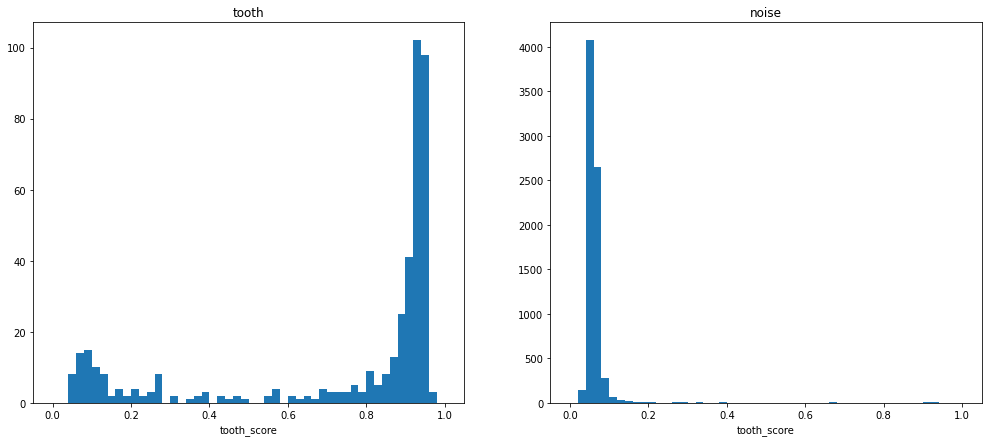

In [18]:
# visualize tooth_score for classes tooth and noise
fig, ax = plt.subplots(1, 2, figsize = (17, 7))
ax[0].hist(df[df['judge'] == 'tp']['enet_score'], range = (0, 1), bins = 50)
ax[1].hist(df[df['judge'] == 'fp']['enet_score'], range = (0, 1), bins = 50)
ax[0].set_title('tooth')
ax[1].set_title('noise')
ax[0].set_xlabel('tooth_score')
ax[1].set_xlabel('tooth_score')
save_path = os.path.join(save_dir, 'histgram.png')
plt.savefig(save_path)
plt.show()

In [19]:
pixel2micron = 0.96# @param {type:"number"}
for index, item in df.iterrows():
    if pd.isnull(item['length']):
        length = pixel2micron * max(item['x_max'] - item['x_min'], item['y_max'] - item['y_min'])
        df.loc[index, 'length'] = length
        df.loc[index, 'length_note'] = 'approx: max(dx, dy)'
df.to_excel(save_excel_path)

In [21]:
from scipy import stats

df_results = pd.DataFrame([])
df_counts = pd.DataFrame([])

for l_thresh in [0, 50, 100, 125, 150, 200, 300]:
    df1 = df[df['length'] >= l_thresh]
    for s_thresh in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]:
        
        df_tp = df1[(df1['judge'] == 'tp') & (df1['enet_score'] >= s_thresh)]
        tp = len(df_tp)
        
        df_fp = df1[(df1['judge'] == 'fp') & (df1['enet_score'] >= s_thresh)]
        fp =len(df_fp)

        df_fn1 = df1[df1['judge'] == 'fn']
        df_fn2 = df1[(df1['judge'] == 'tp') & (df1['enet_score'] < s_thresh)]
        df_fn = pd.concat([df_fn1, df_fn2])
        fn = len(df_fn)

        df_tn = df1[(df1['judge'] == 'fp') & (df1['enet_score'] < s_thresh)]
        tn = len(df_tn)

        df_counts.loc[l_thresh, s_thresh] = f"{tp}, {fp}, {fn}, {tn}"
        if all([tp + fn >= 0, tp + fp >= 0]):
            recall = tp / (tp + fn)
            precision = tp / (tp + fp)
            f_value = stats.hmean([precision, recall])
            # df_recall.loc[l_thresh, f'recall_{s_thresh}'] = recall
            # df_precision.loc[l_thresh, f'precision_{s_thresh}'] = precision
            # df_fValue.loc[l_thresh, f'f_value_{s_thresh}'] = f_value
            df_results.loc[l_thresh, s_thresh] = f'{recall * 100:.1f},  {precision * 100:.1f},  {f_value * 100:.1f}'
        else:
            df_results.loc[l_thresh, s_thresh] = 'no data'
save_counts_path = os.path.join(save_dir, 'tp_fp_fn_tn.xlsx')
save_results_path = os.path.join(save_dir, 'recall_precision_f_value.xlsx')
df_counts.to_excel(save_counts_path)
df_results.to_excel(save_results_path)

print('tp, fp, fn, tn')
display(df_counts)

pd.options.display.precision = 3
print('recall, precision, f_value\n')
display(df_results)

tp, fp, fn, tn


,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60
0,"394, 242, 40, 7141","375, 131, 59, 7252","368, 98, 66, 7285","361, 84, 73, 7299","351, 73, 83, 7310","348, 61, 86, 7322","343, 50, 91, 7333","341, 42, 93, 7341","337, 38, 97, 7345","336, 36, 98, 7347","331, 31, 103, 7352"
50,"364, 200, 38, 6043","346, 106, 56, 6137","339, 79, 63, 6164","333, 67, 69, 6176","324, 57, 78, 6186","321, 46, 81, 6197","319, 36, 83, 6207","317, 30, 85, 6213","313, 27, 89, 6216","312, 25, 90, 6218","308, 21, 94, 6222"
100,"199, 95, 21, 2749","188, 47, 32, 2797","184, 32, 36, 2812","179, 26, 41, 2818","174, 24, 46, 2820","171, 17, 49, 2827","170, 13, 50, 2831","169, 9, 51, 2835","166, 9, 54, 2835","165, 7, 55, 2837","163, 5, 57, 2839"
125,"134, 67, 17, 1571","129, 36, 22, 1602","125, 24, 26, 1614","121, 20, 30, 1618","117, 19, 34, 1619","115, 13, 36, 1625","114, 9, 37, 1629","113, 6, 38, 1632","110, 6, 41, 1632","110, 5, 41, 1633","109, 4, 42, 1634"
150,"86, 41, 11, 898","83, 22, 14, 917","81, 16, 16, 923","79, 14, 18, 925","76, 13, 21, 926","74, 8, 23, 931","73, 6, 24, 933","72, 4, 25, 935","69, 4, 28, 935","69, 4, 28, 935","68, 4, 29, 935"
200,"38, 22, 7, 338","37, 16, 8, 344","37, 12, 8, 348","36, 12, 9, 348","35, 12, 10, 348","33, 7, 12, 353","33, 5, 12, 355","32, 4, 13, 356","29, 4, 16, 356","29, 4, 16, 356","28, 4, 17, 356"
300,"17, 7, 6, 183","16, 5, 7, 185","16, 2, 7, 188","16, 2, 7, 188","16, 2, 7, 188","15, 2, 8, 188","15, 2, 8, 188","14, 2, 9, 188","13, 2, 10, 188","13, 2, 10, 188","12, 2, 11, 188"


recall, precision, f_value



,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60
0,"90.8, 61.9, 73.6","86.4, 74.1, 79.8","84.8, 79.0, 81.8","83.2, 81.1, 82.1","80.9, 82.8, 81.8","80.2, 85.1, 82.6","79.0, 87.3, 83.0","78.6, 89.0, 83.5","77.6, 89.9, 83.3","77.4, 90.3, 83.4","76.3, 91.4, 83.2"
50,"90.5, 64.5, 75.4","86.1, 76.5, 81.0","84.3, 81.1, 82.7","82.8, 83.2, 83.0","80.6, 85.0, 82.8","79.9, 87.5, 83.5","79.4, 89.9, 84.3","78.9, 91.4, 84.6","77.9, 92.1, 84.4","77.6, 92.6, 84.4","76.6, 93.6, 84.3"
100,"90.5, 67.7, 77.4","85.5, 80.0, 82.6","83.6, 85.2, 84.4","81.4, 87.3, 84.2","79.1, 87.9, 83.3","77.7, 91.0, 83.8","77.3, 92.9, 84.4","76.8, 94.9, 84.9","75.5, 94.9, 84.1","75.0, 95.9, 84.2","74.1, 97.0, 84.0"
125,"88.7, 66.7, 76.1","85.4, 78.2, 81.6","82.8, 83.9, 83.3","80.1, 85.8, 82.9","77.5, 86.0, 81.5","76.2, 89.8, 82.4","75.5, 92.7, 83.2","74.8, 95.0, 83.7","72.8, 94.8, 82.4","72.8, 95.7, 82.7","72.2, 96.5, 82.6"
150,"88.7, 67.7, 76.8","85.6, 79.0, 82.2","83.5, 83.5, 83.5","81.4, 84.9, 83.2","78.4, 85.4, 81.7","76.3, 90.2, 82.7","75.3, 92.4, 83.0","74.2, 94.7, 83.2","71.1, 94.5, 81.2","71.1, 94.5, 81.2","70.1, 94.4, 80.5"
200,"84.4, 63.3, 72.4","82.2, 69.8, 75.5","82.2, 75.5, 78.7","80.0, 75.0, 77.4","77.8, 74.5, 76.1","73.3, 82.5, 77.6","73.3, 86.8, 79.5","71.1, 88.9, 79.0","64.4, 87.9, 74.4","64.4, 87.9, 74.4","62.2, 87.5, 72.7"
300,"73.9, 70.8, 72.3","69.6, 76.2, 72.7","69.6, 88.9, 78.0","69.6, 88.9, 78.0","69.6, 88.9, 78.0","65.2, 88.2, 75.0","65.2, 88.2, 75.0","60.9, 87.5, 71.8","56.5, 86.7, 68.4","56.5, 86.7, 68.4","52.2, 85.7, 64.9"


In [22]:
l_thresh, s_thresh = 0, 0.3
df1 = df[df['length'] >= l_thresh]
df_tp = df1[(df1['judge'] == 'tp') & (df1['enet_score'] >= s_thresh)]
df_fp = df1[(df1['judge'] == 'fp') & (df1['enet_score'] >= s_thresh)]
df_fn1 = df1[df1['judge'] == 'fn']
df_fn2 = df1[(df1['judge'] == 'tp') & (df1['enet_score'] < s_thresh)]
df_fn = pd.concat([df_fn1, df_fn2])
print('tp:', len(df_tp))
print('mask-fn:', len(df_fn1), ', enet-fn:', len(df_fn2))

tp: 351
mask-fn: 3 , enet-fn: 80


In [23]:
# save TPs
save_tp_dir = os.path.join(draw_img_dir, 'tooth-tp')
os.makedirs(save_tp_dir, exist_ok=True)

prev_name = ''
for index, item in df_tp.iterrows():
    filename = item['cropped_imgName']
    if filename != prev_name:
        str_slide_No = filename[:-4].split('_')[-3]
        img_path = f"{hirox_image_dir}/{sample_ID}_{str_slide_No}/{filename}"
        crop_img = imread(img_path)
        prev_name = filename
        mean_color = np.round(np.mean(np.mean(crop_img, axis=0), axis=0)).astype(np.uint8)
    box = list(item[['y_min', 'x_min', 'y_max', 'x_max']])
    
    all_points_x = str2array(item['all_points_x'])
    all_points_y = str2array(item['all_points_y'])
    img, img_name, masked = generateImg_from_crop(crop_img, box, filename, margin = 30, 
                                                  all_points_x=all_points_x, all_points_y=all_points_y)
    
    save_path = os.path.join(save_tp_dir, img_name)
    imsave(save_path, img)

print('Done')

Done


In [24]:
# save FNs
save_fn_dir = os.path.join(draw_img_dir, 'tooth-fn')
os.makedirs(save_fn_dir, exist_ok=True)

prev_name = ''
for index, item in df_fn.iterrows():
    filename = item['cropped_imgName']
    if filename != prev_name:
        str_slide_No = filename[:-4].split('_')[-3]
        img_path = f"{hirox_image_dir}/{sample_ID}_{str_slide_No}/{filename}"
        crop_img = imread(img_path)
        prev_name = filename
        mean_color = np.round(np.mean(np.mean(crop_img, axis=0), axis=0)).astype(np.uint8)
    box = list(item[['y_min', 'x_min', 'y_max', 'x_max']])
    
    all_points_x = str2array(item['all_points_x'])
    all_points_y = str2array(item['all_points_y'])
    img, img_name, masked = generateImg_from_crop(crop_img, box, filename, margin = 30, 
                                                  all_points_x=all_points_x, all_points_y=all_points_y)
    save_path = os.path.join(save_fn_dir, img_name)
    imsave(save_path, img)

print('Done')

Done


In [25]:
# save FPs
save_fp_dir = os.path.join(draw_img_dir, 'tooth-fp')
os.makedirs(save_fp_dir, exist_ok=True)

prev_name = ''
for index, item in df_fp.iterrows():
    filename = item['cropped_imgName']
    if filename != prev_name:
        str_slide_No = filename[:-4].split('_')[-3]
        img_path = f"{hirox_image_dir}/{sample_ID}_{str_slide_No}/{filename}"
        crop_img = imread(img_path)
        prev_name = filename
        mean_color = np.round(np.mean(np.mean(crop_img, axis=0), axis=0)).astype(np.uint8)
    box = list(item[['y_min', 'x_min', 'y_max', 'x_max']])
    
    all_points_x = str2array(item['all_points_x'])
    all_points_y = str2array(item['all_points_y'])
    img, img_name, masked = generateImg_from_crop(crop_img, box, filename, margin = 30, 
                                                  all_points_x=all_points_x, all_points_y=all_points_y)
    save_path = os.path.join(save_fp_dir, img_name)
    imsave(save_path, img)

print('Done!')

Done!


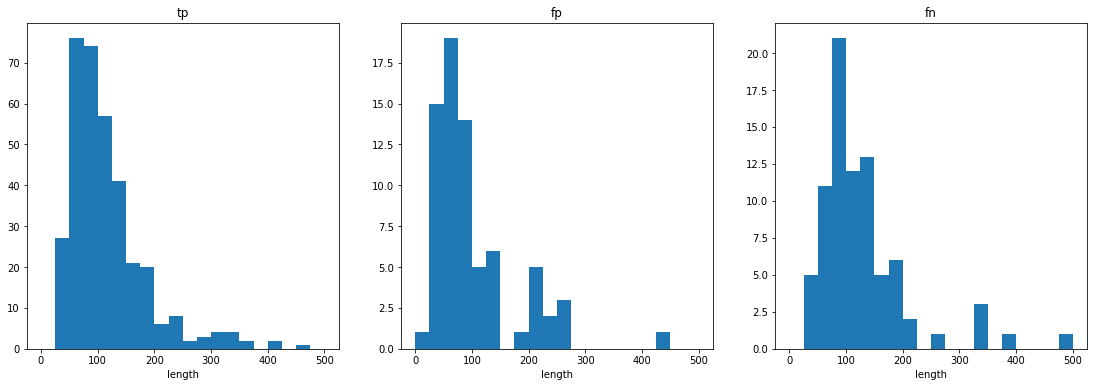

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (19, 6))
ax[0].hist(df_tp['length'], bins=20, range=(0, 500))
ax[1].hist(df_fp['length'], bins=20, range=(0, 500))
ax[2].hist(df_fn['length'], bins=20, range=(0, 500))
ax[0].set_title('tp')
ax[1].set_title('fp')
ax[2].set_title('fn')
for i in range(3):
    ax[i].set_xlabel('length')
plt.show()

In [ ]:
beep()